In [1]:
''' Import packages. '''
# Time packages
import calendar, cftime, datetime, time
# Numerical analysis packages
import numpy as np, random, scipy, numba
# Local data storage packages
import functools, importlib, os, pickle, collections, sys
import pandas as pd, xarray as xr, nc_time_axis
xr.set_options(keep_attrs=True)
# Visualization tools
import cartopy, cartopy.crs as ccrs, matplotlib, matplotlib.pyplot as plt

# Local imports
sys.path.insert(1, '/projects/GEOCLIM/gr7610/scripts')
import derived, utilities, visualization, track_TCs
importlib.reload(track_TCs);
importlib.reload(utilities);
importlib.reload(visualization);
importlib.reload(derived);

#### Generate experiment snapshot

In [3]:
model_name = 'AM2.5'
experiment_name = 'CTL1990.0N'
npes = 540
data_type = 'atmos_4xdaily'
pathname = [f'/scratch/gpfs/GEOCLIM/gr7610/tiger3/{model_name}/work/{experiment_name}_tiger3_intelmpi_24_{npes}PE/POSTP/{year:04d}0101.{data_type}.nc' 
            for year in range(8, 19)]
field_names = ['rh500', 'rh700', 'rh850', 'vort850', 'u_ref', 'v_ref', 't_surf']

In [4]:
TMP = xr.open_mfdataset(pathname)[field_names].load()
TMP = derived.TC_surface_wind_speed(TMP)

In [5]:
filters = {'vort850': {'weight': 1,
                       'threshold': 1e-4},
           'rh500':   {'weight': 0.5,
                       'threshold': 40},
           'rh700':   {'weight': 0.5,
                       'threshold': 60},
           'rh850':   {'weight': 0.5,
                       'threshold': 50},
           'wind':   {'weight': 1,
                       'threshold': 7.5}}

In [6]:
plot_method = 'pcolormesh'

# Initialize dictionary for filtered fields
filtered_fields = {}
# Initialize empty array
frequency = np.full(shape=TMP[field_names[0]].data.shape, fill_value=0., dtype=float)
# Iterate through fields
for field_name in filters.keys():
    weight, threshold = filters[field_name]['weight'], filters[field_name]['threshold']
    filtered_fields[field_name] = weight * xr.where(abs(TMP[field_name]) > threshold, 1, 0)
    frequency += filtered_fields[field_name]

#### Code reproduction

In [12]:
t_surf0 = TMP['t_surf']
sst_cddt = 11.85
dsst_ddt = 5
alpha = (t_surf0 - 273.15 - sst_cddt + dsst_ddt)/dsst_ddt

frequency_filtered = xr.where(frequency >= 3.0, 1, 0)

where_SSTHIGH = xr.where((t_surf0 - 273.15 - sst_cddt) > 0, True, False)
where_SSTLOW = xr.where((t_surf0 - 273.15 - sst_cddt + dsst_ddt) < 0, True, False)
where_SSTTAPER = xr.where(~where_SSTHIGH & ~where_SSTLOW, True, False)

multiplier = lambda x, alpha, low, high: alpha * low + (1 - alpha) * high

In [13]:
freq_HIGH = xr.where(where_SSTHIGH, frequency_filtered, 0)
freq_LOW = xr.where(where_SSTTAPER, multiplier(freq_HIGH, alpha, frequency_filtered, freq_HIGH), freq_HIGH)

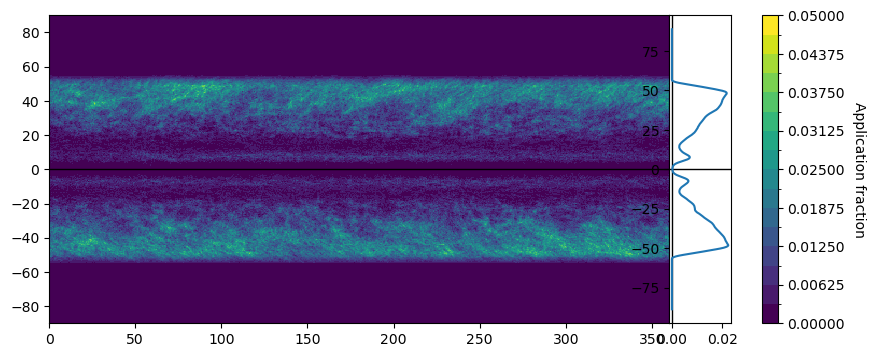

In [14]:
application_frequency_time_averaged = freq_LOW.mean('time')
norm, cmap = visualization.norm_cmap(application_frequency_time_averaged, field='none')

fig, ax = plt.subplots(figsize=(8, 4))
ax.pcolormesh(application_frequency_time_averaged.grid_xt, 
              application_frequency_time_averaged.grid_yt, 
              application_frequency_time_averaged,
              norm=norm, cmap=cmap)

ax.axhline(0, c='k', lw=1)

zonal_mean_ax = ax.inset_axes([1, 0, 0.1, 1])
zonal_mean_ax.axhline(0, c='k', lw=1)
zonal_mean_ax.axvline(0, c='k', lw=1)
zonal_mean_ax.plot(application_frequency_time_averaged.mean('grid_xt').rolling(grid_yt=5, center=True).mean('grid_yt'), 
                   application_frequency_time_averaged.grid_yt)

cax = ax.inset_axes([1.15, 0, 0.025, 1])
colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax)
colorbar.set_label('Application fraction', rotation=270, labelpad=15)

#### Application fraction

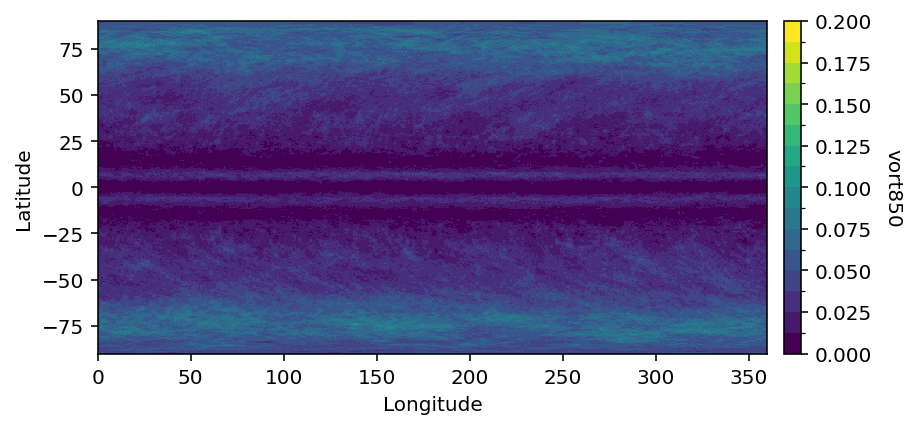

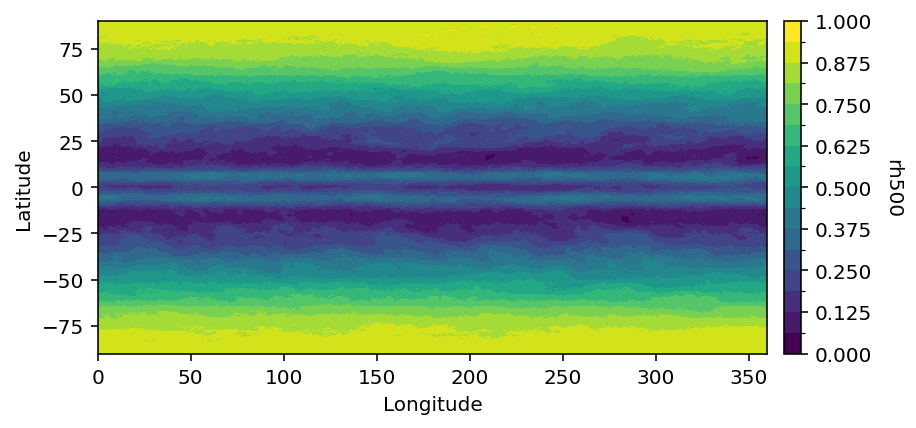

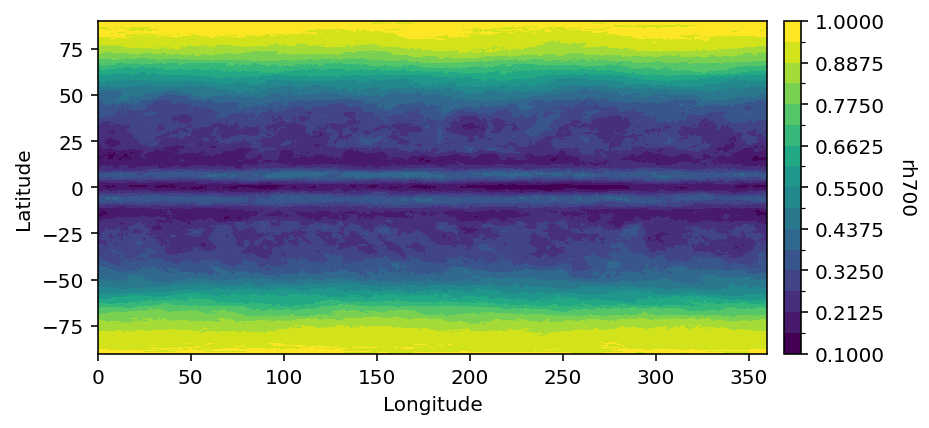

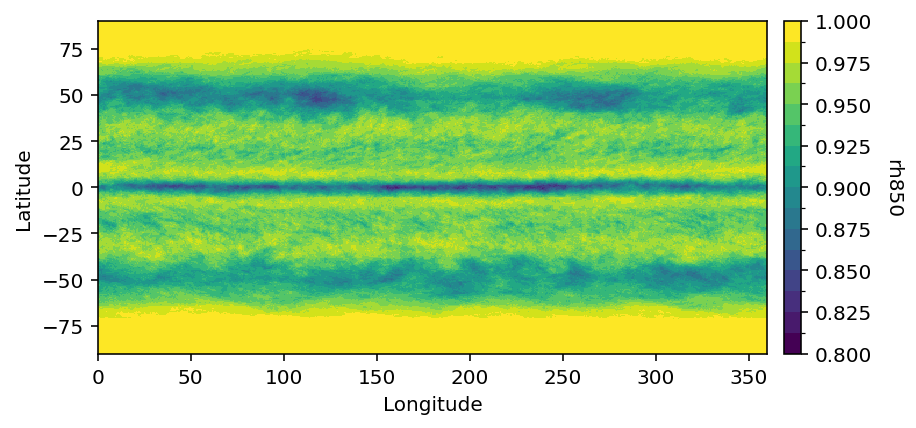

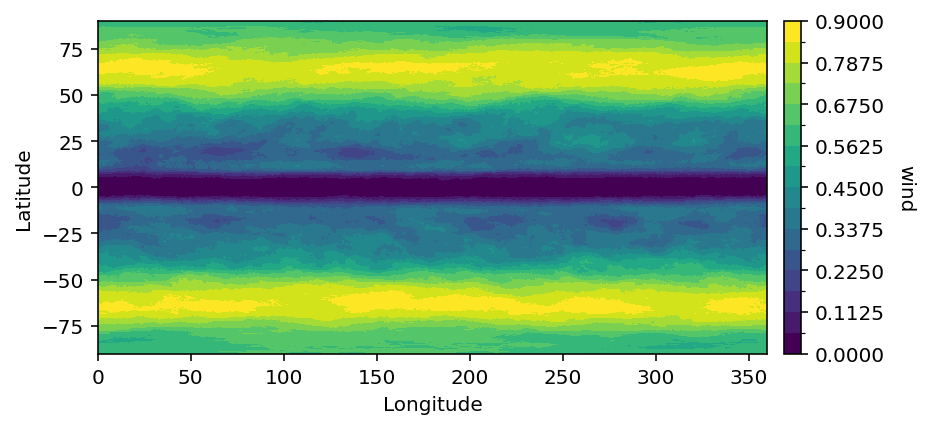

In [11]:
for field in filters.keys():

    iter_field = xr.where(abs(TMP[field]) >= filters[field]['threshold'], 1, 0)
    iter_field = iter_field.mean('time')
    norm, cmap = visualization.norm_cmap(iter_field, field='none')
    
    fig, ax = plt.subplots(figsize=(6, 3), dpi=144)
    ax.pcolormesh(iter_field.grid_xt, iter_field.grid_yt, iter_field,
                  norm=norm, cmap=cmap)

    
    
    cax = ax.inset_axes([1.025, 0, 0.025, 1])
    colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax)
    colorbar.set_label(f'{field}', rotation=270, labelpad=15)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')